#### 1. 라이브러리 호출

In [1]:
import os, cv2
import numpy as np
import wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchmetrics as metrics
import torchvision.models as models

from torchsummary import summary
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

import albumentations as A
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from itertools import product

In [2]:
print(f'torch:', torch.__version__)
print(f'torchvision:', torchvision.__version__)

torch: 1.13.1+cu117
torchvision: 0.14.1+cu117


#### 2. 시드고정

In [3]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random_state = SEED

#### 3. 하이퍼 파라미터 설정

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

lr = 1e-3
batch_size = 32
num_epoch = 5

mean= (0.5, 0.5, 0.5)
std= (0.5, 0.5, 0.5)
image_size = 224

In [5]:
transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
    transforms.RandomRotation((-20, 20)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_val = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_test = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

#### 4. dataloader

In [6]:
# train dataloader

root_path = '/aiffel/aiffel/4. Aiffelthon/classification/dataset/'
train_path = root_path + 'train/'

# ImageFolder를 이용해 폴더명으로 class 지정
train_dataset = ImageFolder(root=train_path,
                     transform=transform_train)

# DataLoader
train_loader = DataLoader(train_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        drop_last=True)

In [7]:
# val dataloader

val_path = root_path + 'val/'

# ImageFolder를 이용해 폴더명으로 class 지정
val_dataset = ImageFolder(root=val_path,
                     transform=transform_val)

# DataLoader
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        drop_last=True)

In [8]:
# test dataloader

test_path = root_path + 'test/'

# ImageFolder를 이용해 폴더명으로 class 지정
test_dataset = ImageFolder(root=test_path,
                     transform=transform_test)

# DataLoader
test_loader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        drop_last=True)

In [9]:
# 클래스 종류
train_dataset.classes

['damage', 'dirt', 'normal']

In [10]:
train_dataset.class_to_idx

{'damage': 0, 'dirt': 1, 'normal': 2}

In [11]:
train_dataset.__len__(), val_dataset.__len__(), test_dataset.__len__()

(4227, 525, 525)

In [12]:
# 배치 1개 추출
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

#### 5. model

In [13]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

In [14]:
model_name = f'{model}'.split('\n')[0].split('(')[0] + '_B0'
model_name

'EfficientNet_B0'

In [15]:
model.classifier[1] = nn.Linear(in_features=1280, out_features=3)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [16]:
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [17]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [18]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=lr, weight_decay=5*1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=20, T_mult=2, eta_min=1e-5)

#### 6. wandb config 생성

In [19]:
train_config = {}
train_config['Batch size'] = batch_size
train_config['Learning Rate'] = lr
train_config['Epochs'] = num_epoch

train_config['Loss fn'] = str(criterion)[:-2]
train_config['Optimizer'] = str(optimizer).split()[0]
train_config['LR Scheduler'] = str(scheduler).split('.')[-1].split()[0]

#### 7. 모델 학습

In [20]:
# Train 함수 정의

def model_train(model, data_loader, criterion, optimzer, device):
    model.train() # 훈련 모드로 설정
    
    train_loss = 0
    acc = 0
    
    progress_bar = tqdm(data_loader)
    
    # mini-batch 학습 시작
    for img, label in progress_bar:
        img, label = img.to(device), label.to(device) # image, label 데이터를 device에 올림
        # 누적 Gradient 초기화
        optimizer.zero_grad()
        # foward propagation
        output = model(img)
        # 손실함수 계산
        loss = criterion(output, label)
        # back propagation
        loss.backward()
        # Gradient 업데이트
        optimizer.step()
        
        _, pred = output.max(dim=1)
        acc += pred.eq(label).sum().item() # 정확히 맞춘 label의 개수
        train_loss += loss.item() * img.size(0) # 배치 전체의 loss
        
    accuracy = acc / len(data_loader.dataset)
    
    return train_loss / len(data_loader.dataset), accuracy

In [21]:
def model_evaluate(model, data_loader, criterion, device):
    model.eval()
    
    with torch.inference_mode():
        acc = 0
        val_loss = 0
        pred_list = []
        label_list = []
        example_img = []

        for b_idx, (img, label) in tqdm(enumerate(data_loader), total=len(data_loader)):
            img, label = img.to(device), label.to(device)
            
            output = model(img)
            _, pred = output.max(dim=1)
            pred_list.append(pred.cpu().numpy())
            label_list.append(label.cpu().numpy())
            
            acc += torch.sum(pred.eq(label)).item()
            val_loss += criterion(output, label).item() * img.size(0)

            if b_idx == 0:
                pred_tensor = pred
                target_tensor = label
                
            MEAN, STD = np.array([0.5, 0.5, 0.5]), np.array([0.5, 0.5, 0.5])
            if b_idx < batch_size:
                img = img[0]
                img = img.cpu()
                img = img.numpy()
                img = np.transpose(img, (1, 2, 0))
                img = (img * STD + MEAN)
                example_img.append(wandb.Image(img, caption=f'Pred:{val_dataset.classes[pred[0].item()]} | Truth: {val_dataset.classes[label[0].item()]}'))
            
            pred_tensor = torch.cat((pred_tensor, pred), dim=0)
            target_tensor = torch.cat((target_tensor, label), dim=0)
        
        f1 = metrics.F1Score(task="multiclass", num_classes=3).to(device)
        
        val_loss = val_loss / len(data_loader.dataset)
        accuracy = acc / len(data_loader.dataset)
        f1_score = f1(pred_tensor, target_tensor)
        return val_loss, accuracy, f1_score.cpu().item(), pred_list, label_list, example_img

In [22]:
# wandb.init(project='classification', name=f'{model_name}', config=train_config, save_code=False)
min_loss = 0.5

for epoch in range(num_epoch):
    train_loss, train_acc = model_train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, f1_score, pred_list, label_list, example_img = model_evaluate(model, val_loader, criterion, device)
    scheduler.step(epoch)

    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), './classification/saved/EfficientNet_B0_Best_Model(2).pth')
    elif epoch % 5==0:
        print('Saving Model!')
        torch.save(model.state_dict(), f'./classification/saved/EfficientNet_B0_{epoch}(2).pth')
        
    print(f'epoch {epoch+1:02d}, train_loss: {train_loss:.5f}, train_accuracy: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}, f1_score: {f1_score:.5f}')
#     wandb.log({'train_loss': train_loss, 'train_accuracy': train_acc, 'val_loss': val_loss, 'val_accuracy': val_acc, 'f1_score': f1_score, 'image':example_img})
# wandb.finish()

100%|██████████| 16/16 [00:19<00:00,  1.23s/it]


Saving Model!
epoch 01, train_loss: 0.97661, train_accuracy: 0.53253, val_loss: 0.81846, val_accuracy: 0.64762, f1_score: 0.66360


100%|██████████| 16/16 [00:20<00:00,  1.26s/it]


epoch 02, train_loss: 0.79372, train_accuracy: 0.67187, val_loss: 0.68106, val_accuracy: 0.72381, f1_score: 0.74265


100%|██████████| 16/16 [00:19<00:00,  1.25s/it]


epoch 03, train_loss: 0.67135, train_accuracy: 0.72297, val_loss: 0.56714, val_accuracy: 0.76000, f1_score: 0.77757


100%|██████████| 16/16 [00:19<00:00,  1.24s/it]


[INFO] val_loss has been improved from 0.50000 to 0.46961. Saving Model!
epoch 04, train_loss: 0.56214, train_accuracy: 0.77644, val_loss: 0.46961, val_accuracy: 0.78667, f1_score: 0.81066


100%|██████████| 16/16 [00:19<00:00,  1.25s/it]

[INFO] val_loss has been improved from 0.46961 to 0.44066. Saving Model!
epoch 05, train_loss: 0.50886, train_accuracy: 0.80317, val_loss: 0.44066, val_accuracy: 0.79810, f1_score: 0.81434


#### 8. 모델 테스트

In [23]:
# 저장된 모델 불러오기
model.load_state_dict(torch.load("./classification/saved/EfficientNet_B0_95.pth"))

<All keys matched successfully>

In [24]:
_, _, _, pred_list, label_list, _ = model_evaluate(model, val_loader, criterion, device)

100%|██████████| 16/16 [00:20<00:00,  1.26s/it]


In [25]:
label = torch.tensor(label_list).view(-1)

/tmp/ipykernel_3805/3665569787.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  label = torch.tensor(label_list).view(-1)


In [26]:
output = torch.tensor(pred_list).view(-1)
output.shape

torch.Size([512])

In [27]:
def plot_confusion_matrix(con_mat, labels, title, cmap=plt.cm.get_cmap('Blues'), center_label=True, normalize=False):
    accuracy = np.trace(con_mat) / float(np.sum(con_mat))
    misclass = 1 - accuracy
    matplotlib.rc('font', size = 20)
    plt.figure(figsize=(10, 10))
    plt.imshow(con_mat, interpolation='nearest', cmap=cmap)
    plt.title(title, pad=50)
    
    marks = np.arange(len(labels))
    
    nlabels = []
    for i in range(len(con_mat)):
        n = sum(con_mat[i])
        nlabel = '{0}'.format(labels[i],n)
        nlabels.append(nlabel)

    thresh = con_mat.max() / 1.5 if normalize else con_mat.max() / 2
        
    if center_label:
        for i, j in product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, "{:,}".format(con_mat[i, j]),
                         horizontalalignment="center",
                         color="white" if con_mat[i, j] > thresh else "black")

    plt.xticks(marks, labels)
    plt.yticks(marks, nlabels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('./classification/saved/confusion_matrix.png', dpi=200

In [28]:
labels = ['damage', 'dirt', 'normal']

In [29]:
con_mat = confusion_matrix(label, output)

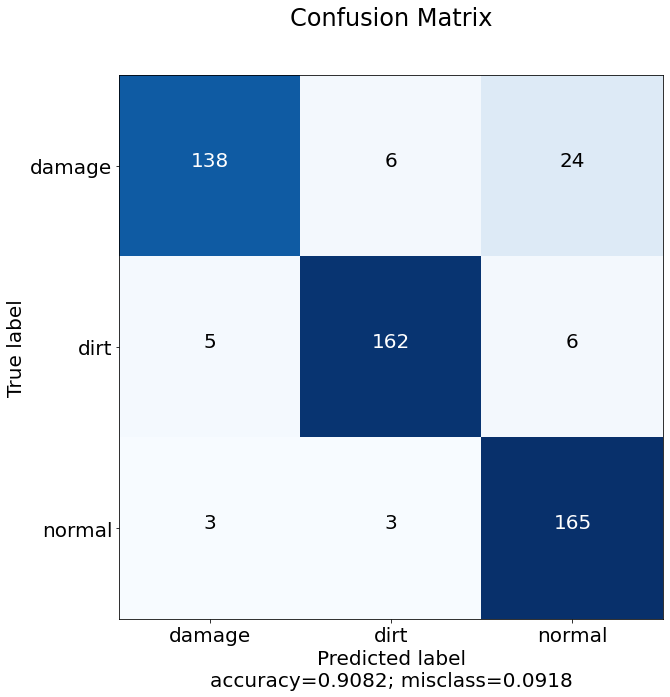

In [30]:
plot_confusion_matrix(con_mat, labels, title='Confusion Matrix', center_label=True)